In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from kerasbeats import prep_time_series, NBeatsModel
from keras import optimizers
import sys
import os
module_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('nbeats.ipynb')),'..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit

In [2]:
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np

class LoadData:
    def __init__(self, stock_name, window_length, slide_range, total_windows):
        """Initializes the LoadData class.

        Args:
            total_windows (int): The total number of windows.
            window_length (int): The length of each window.
        """
        self.stock_name = str(stock_name)
        self.window_length = int(window_length)
        self.slide_range = int(slide_range)
        self.total_windows = int(total_windows)
        
        self.train_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.train_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)
        self.test_data = np.ndarray(shape=(total_windows, window_length), dtype=float)
        self.test_data_index = np.ndarray(shape=(total_windows, window_length), dtype=object)

        self.date_data_start_list = []
        self.date_predict_start_list = []
        self.date_predict_end_list = []
        self.test_data_start_list = []

    def load_and_split_data(self, date_predict_start):
        """Loads and splits the data.

        Args:
            stock_name (str): The stock name.
            date_predict_start (str): The start date for prediction.
            window_length (int): The length of each window.
            slide_range (int): The slide range.
            total_windows (int): The total number of windows.

        Returns:
            train_data: numpy.ndarray
                The training data arrays.
                shape: (number of windows, window_length)
            test_data: numpy.ndarray
                The testing data arrays.
                shape: (number of windows, window_length)
        """

        all_data = yf.Ticker(self.stock_name).history(period='max')
        all_data['Close'] = range(0, len(all_data.index))
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        predict_start = all_data.index.get_loc(date_predict_start)
        for i in range(self.total_windows):
            predict_end = predict_start + self.window_length
            data_start = predict_start - self.window_length
            self.train_data[i, :] = all_data['Close'].iloc[data_start:predict_start].values
            self.train_data_index[i, :] = all_data['Close'].iloc[data_start:predict_start].index
            self.test_data[i, :] = all_data['Close'].iloc[predict_start:predict_end].values
            self.test_data_index[i, :] = all_data['Close'].iloc[predict_start:predict_end].index
            predict_start = predict_start + self.slide_range
        return self.train_data, self.test_data, self.train_data_index, self.test_data_index, all_data

    def _check_start(self, date_predict_start, all_data):
        """Checks the start date for prediction.

        Args:
            date_predict_start (str): The start date for prediction.
            all_data (pandas.DataFrame): The complete data.

        Returns:
            datetime.date: The validated start date for prediction.
        """

        date_predict_start = datetime.datetime.strptime(
            date_predict_start, '%Y-%m-%d').date()
        check = date_predict_start in all_data.index
        while (check == False):
            date_predict_start = date_predict_start + \
                relativedelta(days=+1)
            check = date_predict_start in list(all_data.index)
        return date_predict_start
    
    def load_extra_train_data(self, date_predict_start, train_data_num, x_length):
        extra_train_data = np.ndarray(shape=(1, train_data_num*x_length), dtype=float)
        extra_train_data_index = np.ndarray(shape=(1, train_data_num*x_length), dtype=object)
        all_data = yf.Ticker(self.stock_name).history(period='max')
        all_data['Close'] = range(0, len(all_data.index))
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        data_end = all_data.index.get_loc(date_predict_start)
        data_start = data_end - train_data_num*x_length
        extra_train_data[0, :] = all_data['Close'].iloc[data_start:data_end].values
        extra_train_data_index[0, :] = all_data['Close'].iloc[data_start:data_end].index
        return extra_train_data, extra_train_data_index

In [3]:
stock_name = "^GSPC"
date_predict_start = '2015-01-01'
window_length = 500
slide_range = 50
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 50
y_length = 50
slide = 50

train_data_num = 50
epochs = 50

In [4]:
# dataloader = loadData.LoadData(total_windows, window_length)
dataloader = LoadData(stock_name, window_length, slide_range, total_windows)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)


In [5]:
extra_train_data, extra_train_data_index = dataloader.load_extra_train_data(date_predict_start, train_data_num, x_length)
all_data_index = all_data.index
preprocesser = preprocess.Preprocess()
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(extra_train_data, x_length, y_length, slide=slide)
x_test, y_test, scaler =\
    preprocesser.preprocess_test_data(train_data, test_data, x_length, y_length, slide=slide)

In [6]:
class Nbeats:
    def __init__(self):
        pass
    
    def nbeats(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = NBeatsModel(model_type = 'generic', lookback = 1, horizon = y_length)
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        model = self._construct(y_length)
        # model[i].compile(loss = 'mse',
        #          optimizer = optimizers.RMSprop(0.001))
        # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y

In [7]:

class Lstm:
    def __init__(self):
        pass
    
    def lstm(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length, input_shape):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = Sequential()
        model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 128, return_sequences = True))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 64))
        model.add(Dropout(0.4))
        model.add(Dense(units=y_length))
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        input_shape = (x_train.shape[1],1)
        model = self._construct(y_length, input_shape)
        model.compile(optimizer='adam', 
                    loss='mean_squared_error')
            # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y
    

In [8]:
# model = NBeatsModel(model_type = 'generic', lookback = y_length, horizon = y_length)

In [9]:
# x_train.shape

In [10]:
# x_train[0].flatten().shape

In [11]:
# for i in tqdm(range(0, train_data.shape[0])):
#     earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
#     history = model.fit(x_train[i].flatten(), y_train[i].flatten(), epochs=25)

In [12]:
model = Lstm()
x_train = x_train.reshape((x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[1], y_train.shape[2], 1))


In [13]:
shuffle_index = np.random.permutation(x_train.shape[0])
x_train_shuffled = x_train[shuffle_index]
y_train_shuffled = y_train[shuffle_index]

In [14]:
x_train_shuffled.shape

(2401, 50, 1)

In [15]:
lstm_processed_signal, history = model.lstm(x_train_shuffled, y_train_shuffled, x_test, y_test, train_data, test_data, y_length, epochs)

Epoch 1/50
60/60 [==============================] - 46s 464ms/step - loss: 0.0863 - val_loss: 0.0114
Epoch 2/50
60/60 [==============================] - 22s 370ms/step - loss: 0.0244 - val_loss: 0.0039
Epoch 3/50
60/60 [==============================] - 22s 368ms/step - loss: 0.0170 - val_loss: 0.0014
Epoch 4/50
60/60 [==============================] - 22s 371ms/step - loss: 0.0137 - val_loss: 2.1343e-04
Epoch 5/50
60/60 [==============================] - 28s 468ms/step - loss: 0.0121 - val_loss: 7.7606e-04
Epoch 6/50
60/60 [==============================] - 26s 431ms/step - loss: 0.0105 - val_loss: 0.0021
Epoch 7/50
60/60 [==============================] - 25s 424ms/step - loss: 0.0098 - val_loss: 7.1556e-04
Epoch 8/50
60/60 [==============================] - 23s 380ms/step - loss: 0.0092 - val_loss: 4.9199e-04
Epoch 9/50
60/60 [==============================] - 17s 286ms/step - loss: 0.0083 - val_loss: 0.0013
Epoch 9: early stopping


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


 10%|█         | 1/10 [00:01<00:15,  1.68s/it]

1/1 [==============================] - 0s 75ms/step


 20%|██        | 2/10 [00:01<00:06,  1.31it/s]

1/1 [==============================] - 0s 82ms/step


 30%|███       | 3/10 [00:01<00:03,  2.09it/s]

1/1 [==============================] - 0s 72ms/step


 40%|████      | 4/10 [00:02<00:02,  2.96it/s]

1/1 [==============================] - 0s 76ms/step


 50%|█████     | 5/10 [00:02<00:01,  3.83it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████    | 6/10 [00:02<00:00,  4.54it/s]

1/1 [==============================] - 0s 70ms/step


 70%|███████   | 7/10 [00:02<00:00,  5.34it/s]

1/1 [==============================] - 0s 69ms/step


 80%|████████  | 8/10 [00:02<00:00,  6.09it/s]

1/1 [==============================] - 0s 68ms/step


 90%|█████████ | 9/10 [00:02<00:00,  6.67it/s]

1/1 [==============================] - 0s 69ms/step


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


In [16]:
import matplotlib.pyplot as plt

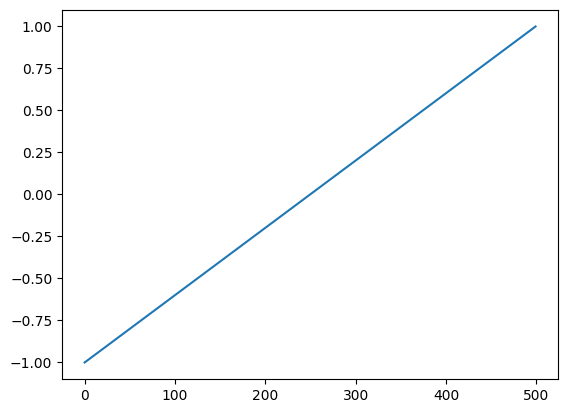

In [17]:
plt.plot(y_test[0].flatten())

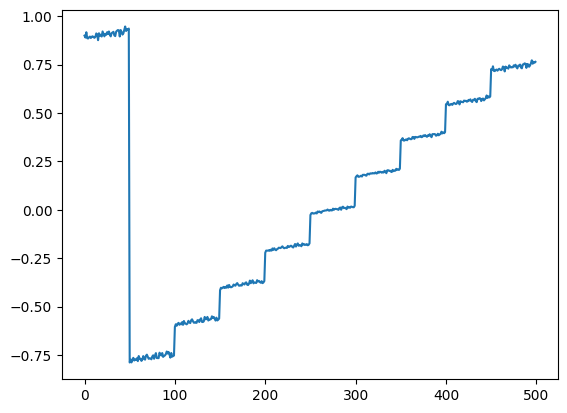

In [18]:
plt.plot(lstm_processed_signal[0].flatten())

In [19]:
# # initialize N-Beats and fit
# nbeats = NBeatsModel(model_type = 'generic', lookback = x_length, horizon = 1)
# nbeats.fit(x_train[0], y_train[0], epochs = 30)

In [20]:
post = postprocess.Postprocess()
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data, pv_range)
pv_test_data = post.find_data_pv(test_data, pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks o

In [21]:
# processed_signal, best_fit_harm, best_fit_error = post.postprocess_fft(
#     mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method)
# pv_signal = post.find_data_pv(processed_signal, pv_range)

In [22]:
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks or valleys lead in data
no peaks o

In [23]:
best_fit_harm = None
best_fit_error = None

In [24]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  497.0


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2015-01-02,2015-01-06,497,2016-12-23,peak,NaN,NaN
1,2015-03-17,2015-03-19,497,2017-03-09,peak,NaN,NaN
2,2015-05-28,2015-06-01,497,2017-05-19,peak,NaN,NaN
3,2015-08-07,2015-08-11,497,2017-08-01,peak,NaN,NaN
4,2015-10-19,2015-10-21,497,2017-10-11,peak,NaN,NaN
5,2015-12-30,2016-01-04,497,2017-12-21,peak,NaN,NaN
6,2016-03-14,2016-03-16,497,2018-03-07,peak,NaN,NaN
7,2016-05-24,2016-05-26,497,2018-05-17,peak,NaN,NaN
8,2016-08-04,2016-08-08,497,2018-07-30,peak,NaN,NaN
9,2016-10-14,2016-10-18,497,2018-10-09,peak,NaN,NaN


evaluater = evaluateProfit.EvaluateProfit()

In [25]:
evaluater = evaluateProfit.EvaluateProfit()

total_profit = -200018.4403076172


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2015-01-06,2022.15,2015-01-15,21860,peak,-19837.85,-9.8103 %
1,2015-03-19,2098.69,2015-03-30,21910,peak,-19811.31,-9.4398 %
2,2015-06-01,2108.64,2015-06-10,21960,peak,-19851.36,-9.4143 %
3,2015-08-11,2102.66,2015-08-20,22010,peak,-19907.34,-9.4677 %
4,2015-10-21,2033.47,2015-10-30,22060,peak,-20026.53,-9.8485 %
5,2016-01-04,2038.2,2016-01-13,22110,peak,-20071.8,-9.8478 %
6,2016-03-16,2014.24,2016-03-28,22160,peak,-20145.76,-10.0017 %
7,2016-05-26,2091.44,2016-06-07,22210,peak,-20118.56,-9.6195 %
8,2016-08-08,2183.76,2016-08-17,22260,peak,-20076.24,-9.1934 %
9,2016-10-18,2138.31,2016-10-27,22310,peak,-20171.69,-9.4335 %


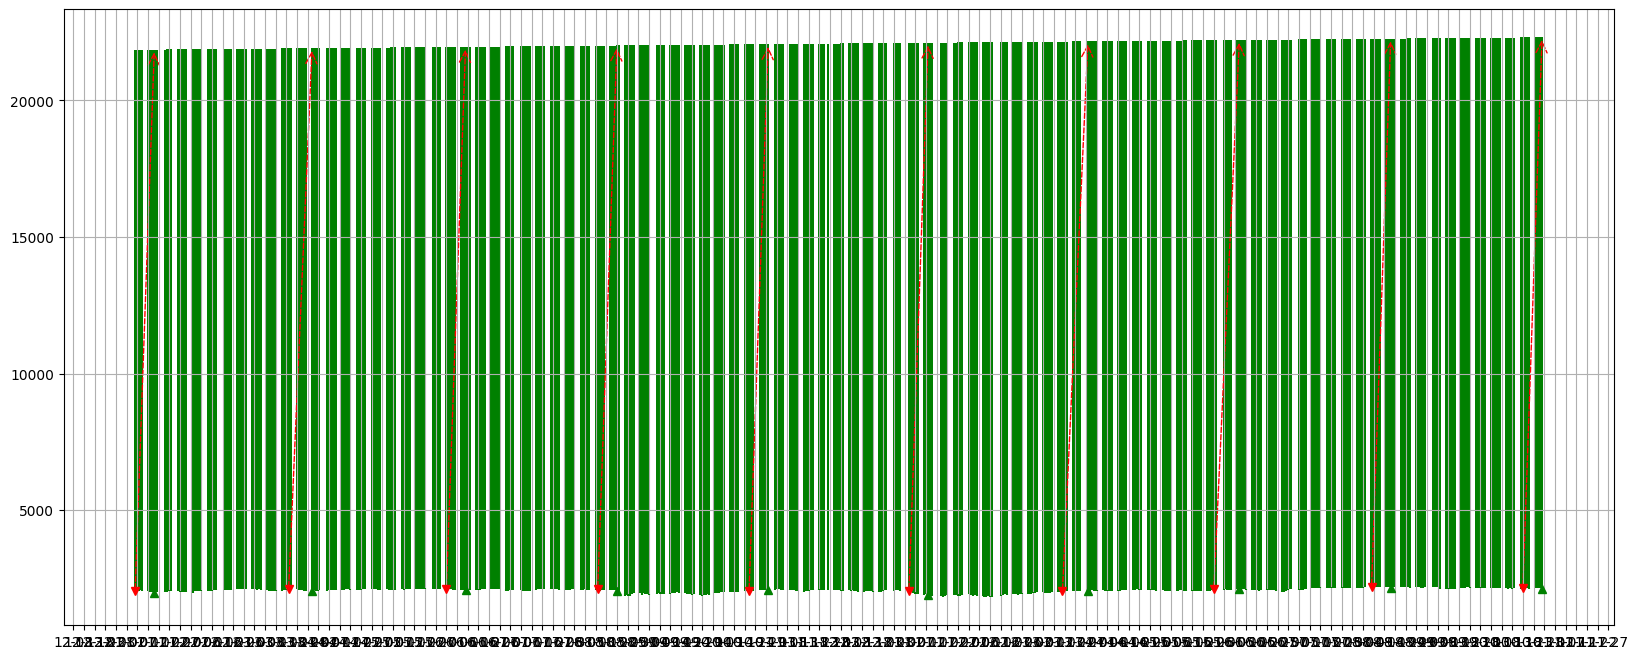

In [26]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = -200018.4403076172


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-06,2022.15,2015-01-15,21860,peak,-19837.85,NaN,NaN,-9.8103 %
1,2015-03-19,2098.69,2015-03-30,21910,peak,-19811.31,NaN,NaN,-9.4398 %
2,2015-06-01,2108.64,2015-06-10,21960,peak,-19851.36,NaN,NaN,-9.4143 %
3,2015-08-11,2102.66,2015-08-20,22010,peak,-19907.34,NaN,NaN,-9.4677 %
4,2015-10-21,2033.47,2015-10-30,22060,peak,-20026.53,NaN,NaN,-9.8485 %
5,2016-01-04,2038.2,2016-01-13,22110,peak,-20071.8,NaN,NaN,-9.8478 %
6,2016-03-16,2014.24,2016-03-28,22160,peak,-20145.76,NaN,NaN,-10.0017 %
7,2016-05-26,2091.44,2016-06-07,22210,peak,-20118.56,NaN,NaN,-9.6195 %
8,2016-08-08,2183.76,2016-08-17,22260,peak,-20076.24,NaN,NaN,-9.1934 %
9,2016-10-18,2138.31,2016-10-27,22310,peak,-20171.69,NaN,NaN,-9.4335 %


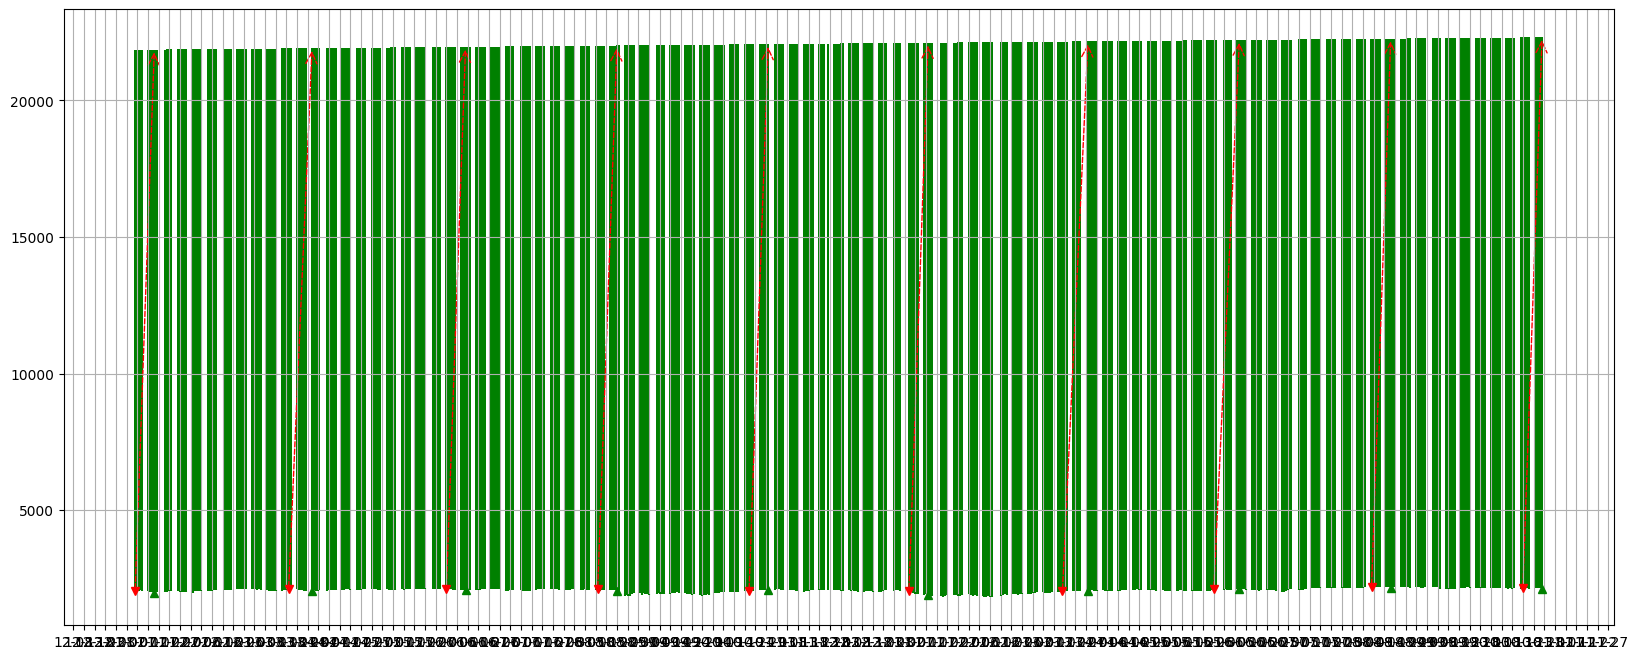

In [27]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = -182276.84030761718


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-06,2022.15,2015-01-06,20103.84,peak,-18081.69,stop_profit,20103.84,-8.9418 %
1,2015-03-19,2098.69,2015-03-19,20149.84,peak,-18051.15,stop_profit,20149.84,-8.6012 %
2,2015-06-01,2108.64,2015-06-01,20195.84,peak,-18087.2,stop_profit,20195.84,-8.5777 %
3,2015-08-11,2102.66,2015-08-11,20241.84,peak,-18139.18,stop_profit,20241.84,-8.6268 %
4,2015-10-21,2033.47,2015-10-21,20287.84,peak,-18254.37,stop_profit,20287.84,-8.977 %
5,2016-01-04,2038.2,2016-01-04,20333.84,peak,-18295.64,stop_profit,20333.84,-8.9764 %
6,2016-03-16,2014.24,2016-03-16,20379.84,peak,-18365.6,stop_profit,20379.84,-9.1179 %
7,2016-05-26,2091.44,2016-05-26,20425.84,peak,-18334.4,stop_profit,20425.84,-8.7664 %
8,2016-08-08,2183.76,2016-08-08,20471.84,peak,-18288.08,stop_profit,20471.84,-8.3746 %
9,2016-10-18,2138.31,2016-10-18,20517.84,peak,-18379.53,stop_profit,20517.84,-8.5954 %


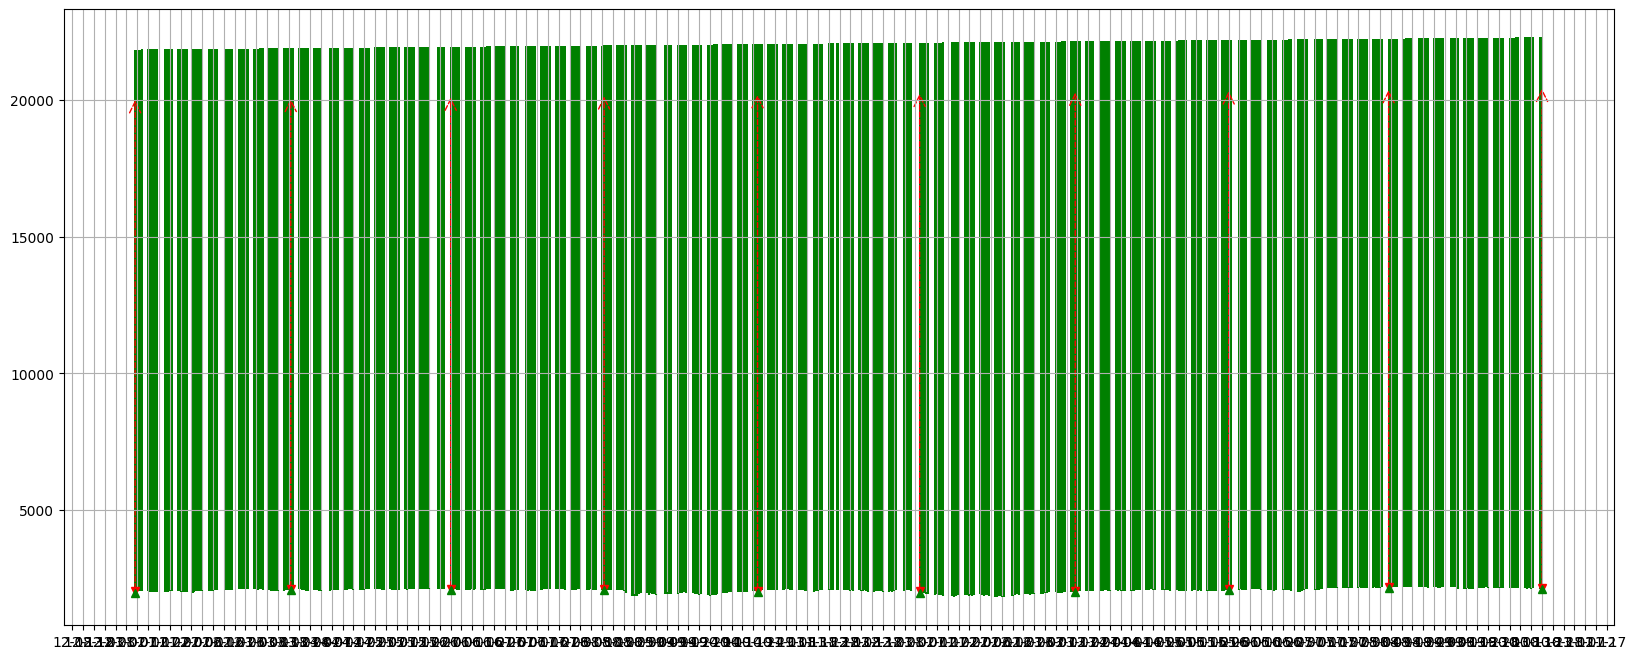

In [28]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

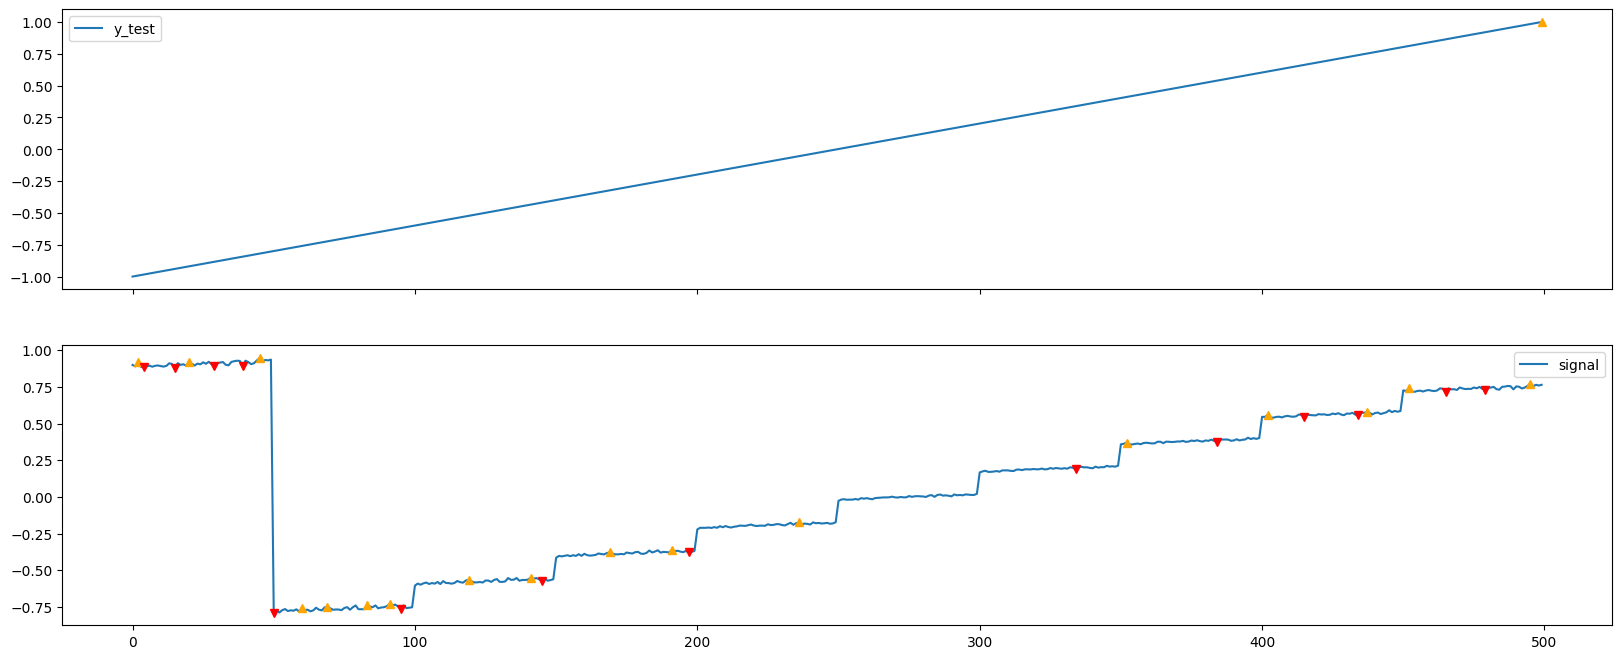

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
ax[0].plot(y_test[0].flatten(), label='y_test')
ax[1].plot(lstm_processed_signal[0].flatten(), label='signal')
for x , pv in enumerate(pv_test_data[0]):
    if pv == 1:
        ax[0].plot(x, y_test[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[0].plot(x, y_test[0].flatten()[x], 'v', color='red')
for x , pv in enumerate(pv_signal[0]):
    if pv == 1:
        ax[1].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
    elif pv == -1:
        ax[1].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
ax[0].legend()
ax[1].legend()
plt.show()

In [30]:
y_test.shape

(10, 10, 50, 1)

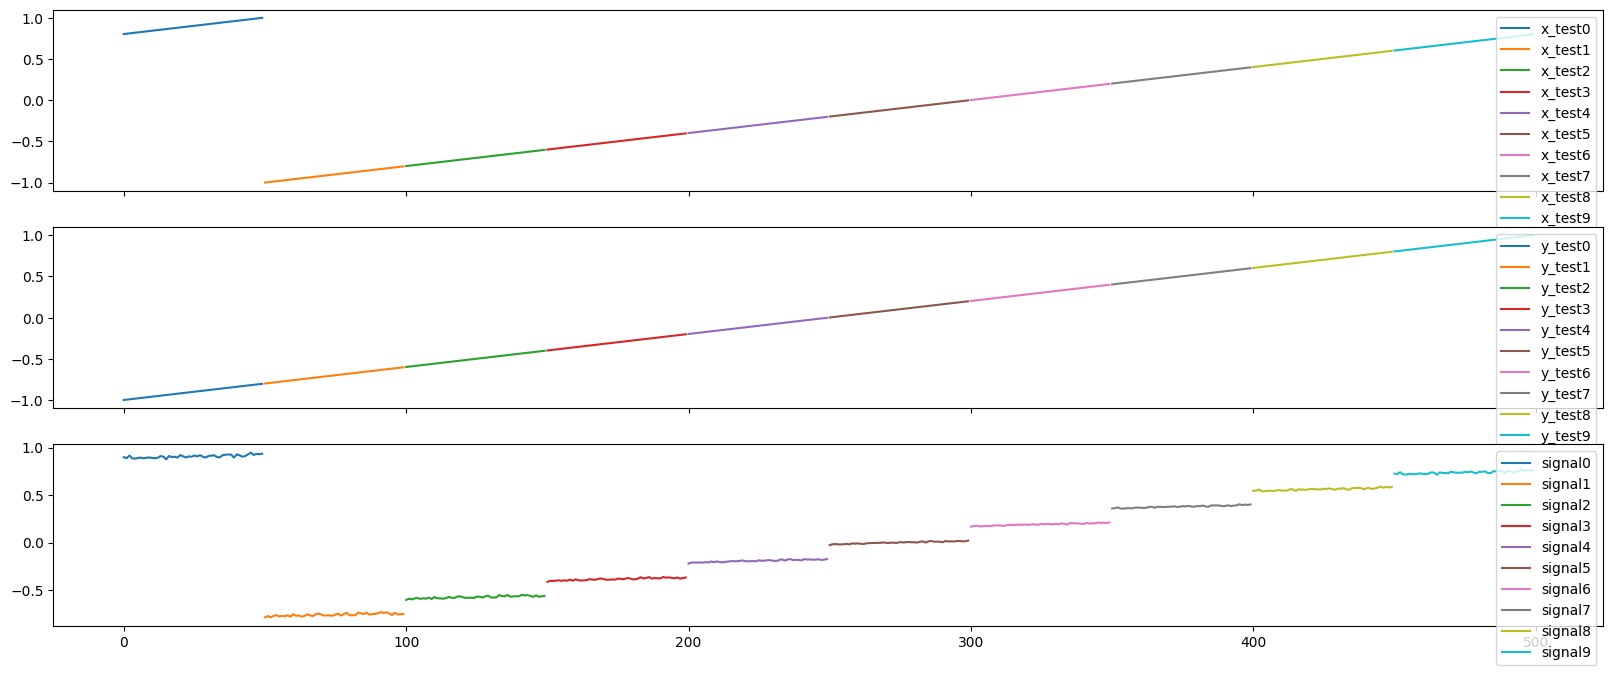

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, 10): 
    countx=range(count, count+y_length)
    ax[0].plot(countx, x_test[0][i], label=f'x_test{i}')
    ax[1].plot(countx, y_test[0][i], label=f'y_test{i}')
    ax[2].plot(countx, lstm_processed_signal[0][i], label=f'signal{i}')
    count+=y_length
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()